In [21]:
import numpy as np

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.weights = None  # Trọng số của các thành phần hỗn hợp (pi_k)
        self.means = None    # Các giá trị trung bình (mu_k)
        self.covariances = None # Các ma trận hiệp phương sai (Sigma_k)
        self.log_likelihood_history = []

    def _multivariate_gaussian_pdf(self, X, mean, cov):
        n_features = X.shape[1]

        cov_for_cholesky = cov + np.eye(n_features) * self.reg_covar

        try:
            L = np.linalg.cholesky(cov_for_cholesky)
        except np.linalg.LinAlgError:
            print(f"Cảnh báo: Phân rã Cholesky thất bại. Ma trận hiệp phương sai có thể không xác định dương. Đang tăng giá trị điều hòa lên {self.reg_covar * 10}.")
            cov_for_cholesky = cov + np.eye(n_features) * (self.reg_covar * 10)
            try:
                L = np.linalg.cholesky(cov_for_cholesky)
            except np.linalg.LinAlgError:
                raise ValueError("Phân rã Cholesky thất bại ngay cả sau khi tăng điều hòa. Hãy kiểm tra dữ liệu hoặc ma trận hiệp phương sai ban đầu.")

        det_cov = np.prod(np.diagonal(L))**2

        X_centered = X - mean

        z = np.linalg.solve(L, X_centered.T).T

        exponent = -0.5 * np.sum(z**2, axis=1)

        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det_cov)

        return norm_const * np.exp(exponent)

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape

        # Khởi tạo các trọng số thành phần bằng nhau
        self.weights = np.ones(self.n_components) / self.n_components

        # Khởi tạo các giá trị trung bình bằng cách chọn ngẫu nhiên các mẫu dữ liệu làm tâm
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]

        # Khởi tạo các ma trận hiệp phương sai là ma trận đơn vị
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

    def _calculate_log_likelihood(self, X, responsibilities, sum_responsibilities_per_sample):
        # Ngăn chặn lỗi log(0) bằng cách cộng một lượng epsilon nhỏ
        return np.sum(np.log(sum_responsibilities_per_sample + 1e-300))


    def fit(self, X):
        n_samples, n_features = X.shape
        self._initialize_parameters(X)
        prev_log_likelihood = -np.inf

        print("Bắt đầu tiến trình huấn luyện GMM (thuật toán EM)...")
        for iteration in range(self.max_iter):
            # Bước E (Expectation)
            cluster_pdfs = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                cluster_pdfs[:, k] = self._multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

            weighted_pdfs = self.weights * cluster_pdfs
            sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)
            responsibilities = weighted_pdfs / (sum_weighted_pdfs + 1e-300)

            # Bước M (Maximization)
            N_k = np.sum(responsibilities, axis=0)

            for k in range(self.n_components):
                # Cập nhật giá trị trung bình
                self.means[k] = np.sum(responsibilities[:, k, np.newaxis] * X, axis=0) / (N_k[k] + 1e-300)

                # Tính toán sai khác giữa dữ liệu và trung bình cụm
                diff = X - self.means[k]
                # Trọng số của mỗi điểm dữ liệu cho cụm k
                weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
                # Tính tổng có trọng số của tích ngoài (x_n - mu_k)(x_n - mu_k)^T
                # weighted_diff.T có dạng (n_features, n_samples)
                # diff có dạng (n_samples, n_features)
                self.covariances[k] = (weighted_diff.T @ diff) / (N_k[k] + 1e-300)

                # Áp dụng thêm phần điều hòa trực tiếp vào ma trận hiệp phương sai sau khi cập nhật
                self.covariances[k] += np.eye(n_features) * self.reg_covar

            self.weights = N_k / (n_samples + 1e-300)

            current_log_likelihood = self._calculate_log_likelihood(X, responsibilities, sum_weighted_pdfs)
            self.log_likelihood_history.append(current_log_likelihood)

            print(f"Vòng lặp {iteration+1}/{self.max_iter}")

            if iteration > 0 and np.abs(current_log_likelihood - prev_log_likelihood) < self.tol:
                print(f"GMM đã đạt điểm hội tụ tại vòng lặp {iteration+1}")
                break
            prev_log_likelihood = current_log_likelihood
        print("Tiến trình huấn luyện GMM đã hoàn thành.")

    def predict_proba(self, X):
        n_samples = X.shape[0]
        cluster_pdfs = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            cluster_pdfs[:, k] = self._multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

        weighted_pdfs = self.weights * cluster_pdfs
        sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)

        # Bổ sung epsilon để tránh tình trạng chia cho 0
        return weighted_pdfs / (sum_weighted_pdfs + 1e-300)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def remove_background_with_gmm(image_path, gmm_model, display=True):
    # Đọc và xử lý ảnh đầu vào
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    H, W, C = img_array.shape

    # Chuẩn hóa giá trị màu RGB
    X_rgb = img_array.reshape(-1, 3) / 255.0

    # Chuyển đổi sang hệ màu HSV và tiến hành chuẩn hóa
    img_hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    X_hsv = img_hsv.reshape(-1, 3) / [179.0, 255.0, 255.0] # Chuẩn hóa H(0-179), S(0-255), V(0-255)

    # Chuẩn hóa dữ liệu vị trí (tọa độ pixel)
    x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))
    X_pos = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2) / max(H, W)

    # Xây dựng tập đặc trưng: màu RGB + màu HSV + vị trí
    X = np.concatenate([X_rgb, X_hsv, X_pos], axis=1)

    # Huấn luyện mô hình GMM
    gmm_model.fit(X)
    labels = gmm_model.predict(X)

    # Xác định nhãn của vùng nền là cụm có kích thước lớn nhất
    (unique, counts) = np.unique(labels, return_counts=True)
    bg_label = unique[np.argmax(counts)]

    # Tạo ra một ảnh mới với kênh alpha (RGBA)
    foreground = img_array.reshape(-1, 3).copy()
    alpha_channel = np.ones((H * W,), dtype=np.uint8) * 255
    alpha_channel[labels == bg_label] = 0  # Đặt vùng nền trong suốt

    rgba_img = np.concatenate([
        foreground,                     # Kênh màu RGB
        alpha_channel[:, np.newaxis]   # Kênh Alpha
    ], axis=1).reshape(H, W, 4)

    result_img = Image.fromarray(rgba_img.astype(np.uint8), mode='RGBA')

    if display:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Hình ảnh gốc")
        plt.imshow(img_array)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Kết quả loại bỏ nền")
        plt.imshow(result_img)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return result_img, labels.reshape(H, W)

In [23]:
from google.colab import files
uploaded = files.upload()

Saving zebra.jpg to zebra.jpg


In [24]:
!pip install opencv-python

Bắt đầu tiến trình huấn luyện GMM (thuật toán EM)...
Vòng lặp 1/100
Vòng lặp 2/100
Vòng lặp 3/100
Vòng lặp 4/100
Vòng lặp 5/100
Vòng lặp 6/100
Vòng lặp 7/100
Vòng lặp 8/100
Vòng lặp 9/100
Vòng lặp 10/100
Vòng lặp 11/100
Vòng lặp 12/100
Vòng lặp 13/100
Vòng lặp 14/100
Vòng lặp 15/100
Vòng lặp 16/100
Vòng lặp 17/100
Vòng lặp 18/100
Vòng lặp 19/100
Vòng lặp 20/100
Vòng lặp 21/100
Vòng lặp 22/100
Vòng lặp 23/100
Vòng lặp 24/100
Vòng lặp 25/100
Vòng lặp 26/100
Vòng lặp 27/100
Vòng lặp 28/100
Vòng lặp 29/100
Vòng lặp 30/100
Vòng lặp 31/100
Vòng lặp 32/100
Vòng lặp 33/100
Vòng lặp 34/100
Vòng lặp 35/100
Vòng lặp 36/100
Vòng lặp 37/100
Vòng lặp 38/100
Vòng lặp 39/100
Vòng lặp 40/100
Vòng lặp 41/100
Vòng lặp 42/100
Vòng lặp 43/100
Vòng lặp 44/100
Vòng lặp 45/100
Vòng lặp 46/100
Vòng lặp 47/100
Vòng lặp 48/100
Vòng lặp 49/100
Vòng lặp 50/100
Vòng lặp 51/100
Vòng lặp 52/100
Vòng lặp 53/100
Vòng lặp 54/100
Vòng lặp 55/100
Vòng lặp 56/100
Vòng lặp 57/100
Vòng lặp 58/100
Vòng lặp 59/100
Vòng lặp 60/

/tmp/ipython-input-2908817445.py:44: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  result_img = Image.fromarray(rgba_img.astype(np.uint8), mode='RGBA')


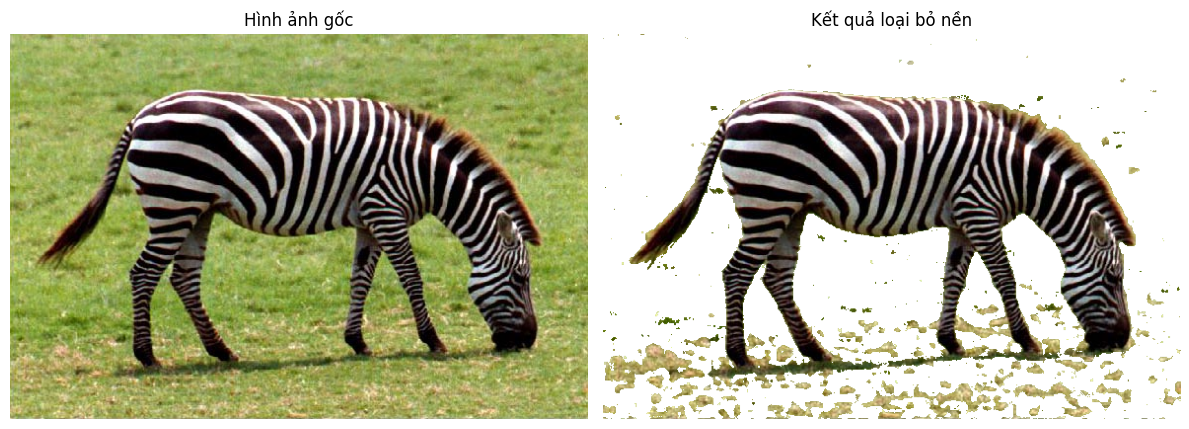

In [25]:
gmm = GMM(n_components=2)
result_img, pixel_labels = remove_background_with_gmm("zebra.jpg", gmm)

In [26]:
result_img.save("zebra_transparent1.png")

In [27]:
import numpy as np
from PIL import Image
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

def remove_background_with_transparency(image_path, n_components=3, save_path="output.png", display=True):
    # Đọc hình ảnh và chuyển đổi sang định dạng RGB
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    H, W, C = img_np.shape

    # Chuẩn bị dữ liệu đầu vào cho mô hình GMM (chỉ sử dụng kênh màu RGB)
    X = img_np.reshape(-1, 3)

    # Áp dụng thuật toán GMM từ thư viện scikit-learn
    gmm = GaussianMixture(n_components=n_components, covariance_type='tied', random_state=0)
    gmm.fit(X)
    labels = gmm.predict(X)

    # Xác định vùng nền là cụm có số lượng pixel lớn nhất
    unique, counts = np.unique(labels, return_counts=True)
    bg_label = unique[np.argmax(counts)]

    # Tạo ra một ảnh RGBA (bao gồm kênh alpha)
    rgba = np.concatenate([img_np.reshape(-1, 3), np.ones((H * W, 1)) * 255], axis=1)  # Kênh alpha mặc định là 255
    rgba[labels == bg_label, 3] = 0  # Đặt giá trị alpha = 0 cho các pixel nền (làm cho chúng trong suốt)

    rgba = rgba.reshape(H, W, 4).astype(np.uint8)
    transparent_img = Image.fromarray(rgba, 'RGBA')

    # Lưu ảnh kết quả
    transparent_img.save(save_path)

    # Hiển thị kết quả nếu được yêu cầu
    if display:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Hình ảnh gốc")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Hình ảnh với nền trong suốt")
        plt.imshow(transparent_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return transparent_img

/tmp/ipython-input-3841558127.py:29: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  transparent_img = Image.fromarray(rgba, 'RGBA')


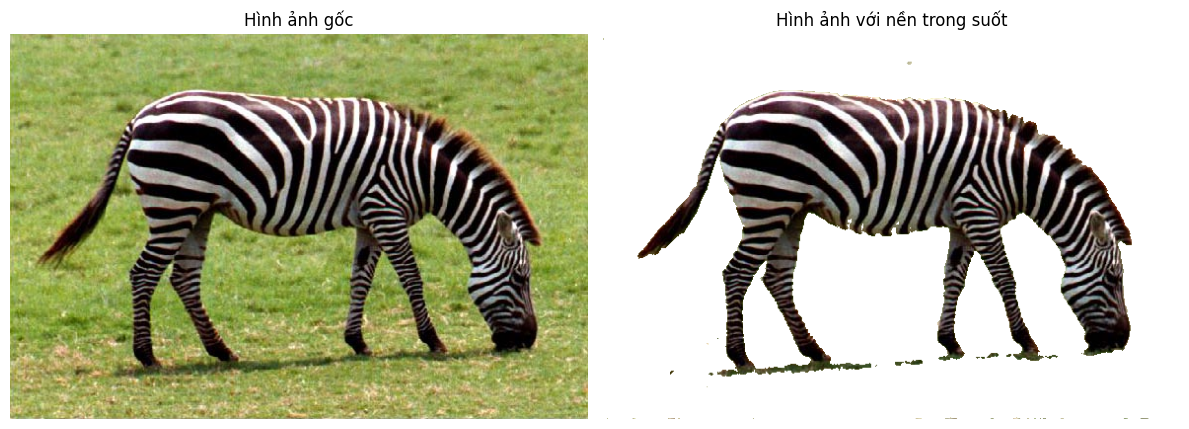

In [28]:
# Gọi hàm
result_img_sk = remove_background_with_transparency("zebra.jpg", n_components=3)

# Lưu ảnh có nền trong suốt
result_img_sk.save("zebra_transparent.png")
